Code to correct the aberration mainly introcuded by the R11 SLM. This work is based on Mark Neil's Matlab code:`startestWFSnew.m`.

In [1]:
import sys
print(sys.path)

['C:\\Users\\ML2618\\PycharmProjects\\HexSimInstrument', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\python38.zip', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\DLLs', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib', '', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib\\site-packages', 'C:\\Users\\ML2618\\PycharmProjects\\napari-pcd-reader_draft\\src', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib\\site-packages\\win32', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib\\site-packages\\win32\\lib', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib\\site-packages\\Pythonwin']


In [1]:
import numpy as np
#import cupy as cp
cp = None
from scipy.signal import convolve2d
import scipy.ndimage
import matplotlib.pyplot as plt
import time
from IPython import display
import cv2
# import cupyx.scipy.ndimage
import opt_einsum as oe

# Aberration correction simulation

In [2]:
xp = np
# titles = ['Guess for PSF intensity', 'Phase sum in pupil', 'Phase difference in pupil', 'Amplitude in pupil', 'Amplitude profile in pupil', 'Unwrapped PSF phase', 'Unwrapped PSF phase difference', 'Simulated phase aberration', 'Simulated phase aberration sum', 'Measured PSF', 'Measured PSF+defocus', 'Measured PSF-defocus'
titles = ['Guess for PSF intensity', 'Phase sum in pupil', 'Phase difference in pupil', 'Amplitude in pupil', 'Amplitude profile in pupil', 'Unwrapped PSF phase', 'Zernike fitted phase', 'Simulated phase aberration', 'Simulated phase aberration sum', 'Measured PSF', 'Measured PSF+defocus', 'Measured PSF-defocus']

In [3]:
# Scaling calculation all distances in µm

# camera pixel size
d_c = 5.04
# camera roi size
N = 256

# slm pixel size
d_s = 8.2
# slm roi size
n_s = 2048

# fourier focal length
f = 300e3
# wavelength
l = 0.52

In [4]:
# Sampling in pupil plane
s_p = f * l / (N * d_c)
print(f's_p = {s_p:.3f}')

# pupil plane diameter in pixels
d_p = n_s * d_s / s_p
print(f'd_p = {d_p:.3f}')

s_p = 120.908
d_p = 138.896


In [5]:
# Scaling from pupil plane to SLM plane
s_fac = n_s / d_p
print(f's_fac = {s_fac:.3f}') 

s_fac = 14.745


Set up arrays

In [6]:
x, y = xp.meshgrid(xp.linspace(-N / d_p, N / d_p, N), xp.linspace(-N / d_p, N / d_p, N))
r = xp.sqrt(x ** 2 + y ** 2)
theta = xp.arctan2(y, x)
circ = r < 1
g = xp.exp(-r ** 2 / 2 / (0.5 ** 2))  # weight the target PSF towards the centre
G = xp.zeros((int(N), int(N)))
G = g
normval = xp.sum(circ)

Zernike aberrations

In [7]:
Z00 = xp.ones_like(x) * circ
Z11 = 2 * r * xp.cos(theta) * circ
Z1_1 = 2 * r * xp.sin(theta) *circ
Z20 = xp.sqrt(3) * (2 * r ** 2 - 1) * circ
Z22 = xp.sqrt(6) * r ** 2 * xp.cos(2 * theta) * circ
Z2_2 = xp.sqrt(6) * r ** 2 * xp.sin(2 * theta) * circ
Z31 = 2 * xp.sqrt(2) * (3 * r ** 3 - 2 * r) * xp.cos(theta) * circ
Z3_1 = 2 * xp.sqrt(2) * (3 * r ** 3 - 2 * r) * xp.sin(theta) * circ
Z33 = 2 * xp.sqrt(2) * r ** 3 * xp.cos(3 * theta) * circ
Z3_3 = 2 * xp.sqrt(2) * r ** 3 * xp.sin(3 * theta) * circ
Z40 = xp.sqrt(5) * (6 * r ** 4 - 6 * r ** 2 + 1) * circ
Z42 = xp.sqrt(10) * (4 * r ** 4 - 3 * r ** 2) * xp.cos(2 * theta) * circ
Z4_2 = xp.sqrt(10) * (4 * r ** 4 - 3 * r ** 2) * xp.sin(2 * theta) * circ
Z44 = xp.sqrt(10) * r ** 4 * xp.cos(4 * theta) * circ
Z4_4 = xp.sqrt(10) * r ** 4 * xp.sin(4 * theta) * circ
Z51 = 2 * xp.sqrt(3) * (10 * r ** 5 - 12 * r ** 3 + 3 * r) * xp.cos(theta) * circ
Z5_1 = 2 * xp.sqrt(3) * (10 * r ** 5 - 12 * r ** 3 + 3 * r) * xp.sin(theta) * circ
Z53 = 2 * xp.sqrt(3) * (5 * r ** 5 - 4 * r ** 3) * xp.cos(3 * theta) * circ
Z5_3 = 2 * xp.sqrt(3) * (5 * r ** 5 - 4 * r ** 3) * xp.sin(3 * theta) * circ
Z55 = xp.sqrt(12) * r ** 5 * xp.cos(5 * theta) * circ
Z5_5 = xp.sqrt(12) * r ** 5 * xp.sin(5 * theta) * circ

## SLM's aberration
### Random phase
Create a random image with low spatial frequency content for aberration to be measured

In [8]:
# ri0 = xp.random.rand(N, N) - 0.5
# kern = xp.reshape(xp.exp(-r ** 2 / (2 * 0.35 ** 2)), (N, N))
# if xp == cp:
#     ri = xp.array(convolve2d(ri0.get(), kern.get(), mode='same')) * circ / 2
# else:
#     ri = convolve2d(ri0, kern, mode='same') * circ / 1
# % ri = imresize(ri,10,'bicubic')
# % ri = 1.0*ri(9*N/2:11*N/2-1,9*N/2:11*N/2-1).*circ+atan2(y-0.5,x-0.3).*circ-atan2(y+0.4,x-0.3).*circ
# % ri = (2*ri(9*N/2:11*N/2-1,9*N/2:11*N/2-1)+2*Z40+2*Z11+1*Z2_2+2*Z11).*circ
ri = (30 * Z22 + 2 * Z2_2 - 5 * Z31 + 7 * Z3_1 + 5 * Z33 - 2 * Z3_3) * circ / 2

# for the starting test aberration
# x2, y2 = xp.meshgrid(xp.linspace(-0.2, 0.2, N), xp.linspace(-0.2, 0.2, N))
# r2 = xp.sqrt(x2 ** 2 + y2 ** 2)  # starting random input phase
# r2 = xp.sqrt(x ** 2 + y ** 2)  # starting random input phase
# ri2 = xp.random.rand(N, N) - 0.5
ri2 = (-18 * Z11 + 5 * Z22 - 7 * Z31 + 11 * Z3_3) * circ
# kern = xp.exp(-r2 ** 2 / (2 * 0.35 ** 2))
# if xp == cp:
#     ri2 = xp.array(convolve2d(ri2.get(), kern.get()))
# else:
#     ri2 = convolve2d(ri2, kern)
# ri2 = xp.reshape(ri2,ri2.shape * 10)
# ri2 = 1.0 * ri2[int(N / 2):int(3 * N / 2), int(N / 2):int(3 * N / 2)] * circ

Work out measured PSFs for the 3 applied masks

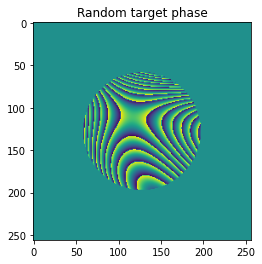

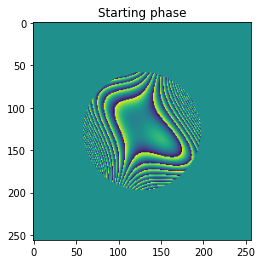

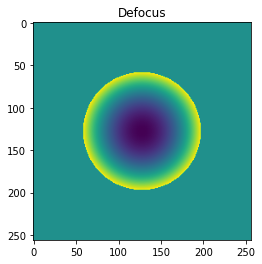

In [9]:
plt.figure(100)
if xp == cp:
    plt.imshow((xp.angle(xp.exp(1j * ri))).get())
else:
    plt.imshow(xp.angle(xp.exp(1j * ri)))
plt.title('Random target phase')

sumc = xp.sum(circ)
piston = xp.sum(xp.sum(ri * circ)) / sumc
diff = (ri-piston) * circ
rms = xp.sqrt(xp.sum(diff ** 2) / sumc)

plt.figure(101)
hlx = theta * circ  # helical wavefront
if xp == cp:
    plt.imshow(xp.angle(xp.exp(1j*ri2)).get())
else:
    plt.imshow(xp.angle(xp.exp(1j*ri2)))
plt.title('Starting phase')

plt.figure(102)
defocus = 5 * Z20
asti1 = 5 * Z22
asti2 = 5 * Z2_2
bias = [7.5 * Z20, 0 * Z20, -7.5 * Z20]
if xp == cp:
    plt.imshow(defocus.get())
else:
    plt.imshow(defocus)
plt.title('Defocus')

ampl = circ * xp.exp(-((x - 0.25) ** 2 + 2 * y ** 2) / 2 / 1 ** 2)  # funny gaussian illumination to simulate a laser beam scenario; sigma=1

In [10]:
nphot = 1e8  # Number of photons per detected image
bg = xp.ones((int(N), int(N))) * 0  # background

### 3 PSFs
Apply three masks

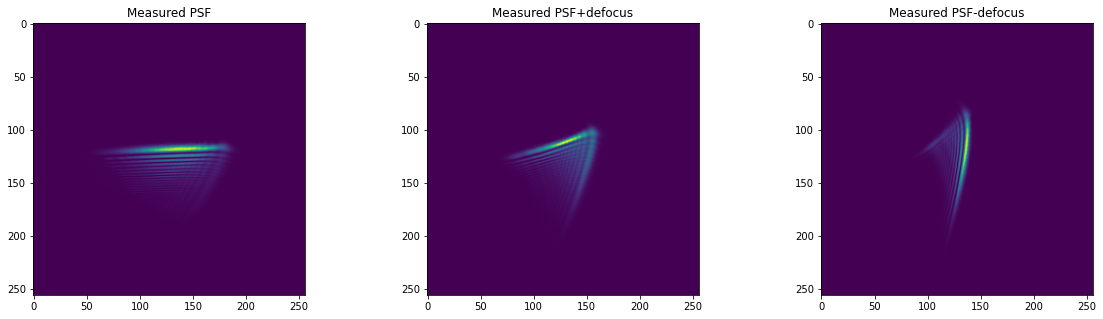

In [14]:
masks = [ri + bias[0], ri + bias[1], ri + bias[2]]
psfi = [None, None, None]  # psf intensity
psfn = [None, None, None]
plt.figure(figsize=(20,5))
for i in range(3):
    p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * masks[i])))
    p1i = xp.abs(p1) ** 2 / xp.sum(xp.abs(p1) ** 2) * nphot + bg
    p1i_n = (xp.random.poisson(p1i) - bg) * G
    ps = p1i_n  # PSF intensity with noise
    plt.subplot(1, 3, i + 1)
    plt.title(titles[9 + i])
    if xp == cp:
        plt.imshow(ps.get())
    else:
        plt.imshow(ps)
    psfi[i] = p1i_n + 0j


## Iteration loop to correct aberrations

In [15]:
cumphase = xp.zeros((N, N))
Q = circ * xp.exp(1j * ri2)
rms_plot = []
z_a_p = [Z11, Z1_1, Z20, Z22, Z2_2, Z31, Z3_1, Z33, Z3_3, Z40, Z42, Z4_2, Z44, Z4_4, Z51, Z5_1, Z53, Z5_3, Z55,Z5_5]  # Zernike aberration for phase
z_array = xp.zeros((len(z_a_p), N, N))
for i in range(len(z_a_p)):
    z_array[i] = z_a_p[i]    
cum_z = xp.zeros(len(z_a_p))

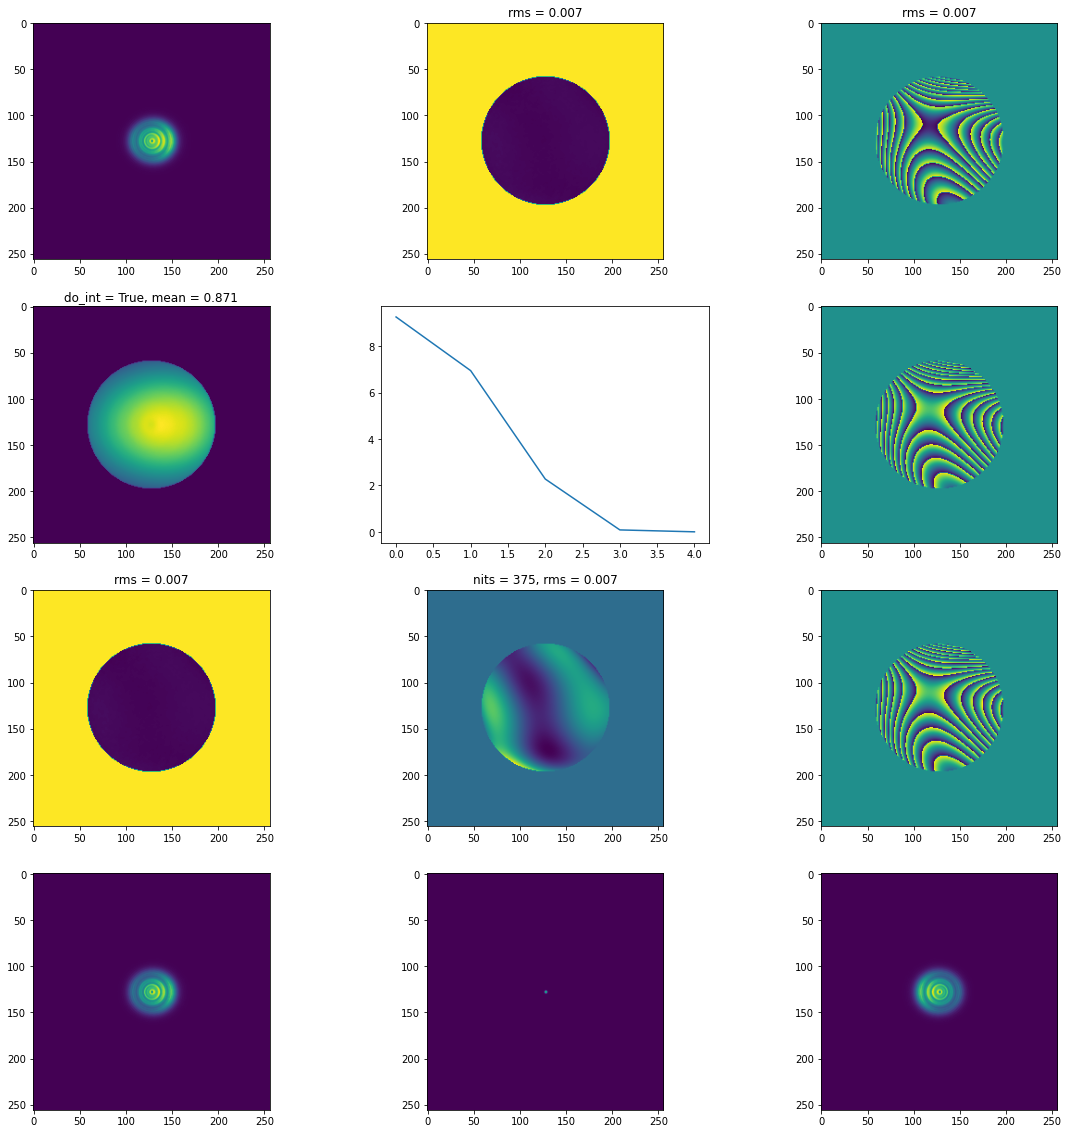

Elapsed time: 23.264948844909668s
[-0.    -0.001  0.002 14.999  1.    -2.501  3.5    2.5   -1.     0.001
 -0.     0.    -0.001  0.    -0.    -0.    -0.    -0.    -0.    -0.   ]


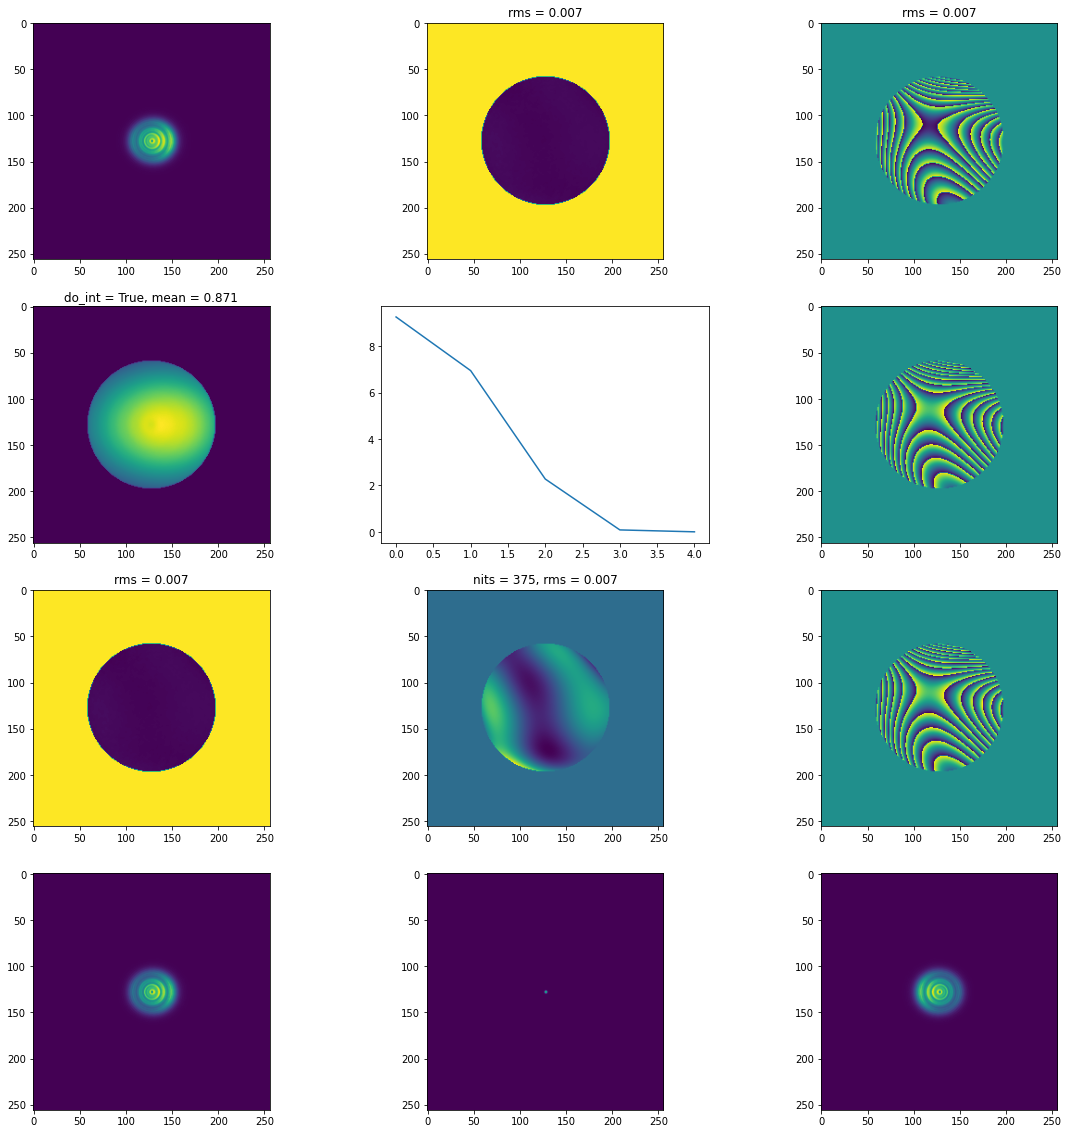

In [16]:
show_ani = True
if show_ani:
    f = plt.figure(figsize=(20,20))
    axes = []
    for i in range(12):
        axes.append(f.add_subplot(4,3,i+1))

def show_animation(k, img, title=None):
    if show_ani:
        axes[k].clear()
        if xp == cp:
            s = axes[k].imshow(img.get())
        else:
            s = axes[k].imshow(img)
        if not title is None:
            axes[k].set_title(title)
        if k == 11:
            display.clear_output(wait=True)
            display.display(axes[k].get_figure())

t0 = time.time()
nits = 1
n = 75
error = 0
psfn0 = [None, None, None]

do_int = False
last_rms = 10.0

while nits < n * 30 + 1:
    q1 = xp.fft.fftshift(xp.fft.fft2(Q * xp.exp(1j * bias[0])))
    q2 = xp.fft.fftshift(xp.fft.fft2(Q * xp.exp(1j * bias[1])))
    q3 = xp.fft.fftshift(xp.fft.fft2(Q * xp.exp(1j * bias[2])))
    q1s = q1

    if xp.mod(nits, n) == 0:
        show_animation(0,abs(q1s) ** 2)

    Q1 = xp.fft.ifft2(xp.fft.fftshift(xp.sqrt(psfi[0]) * xp.exp(1j * xp.angle(q1))))
    Q1 = Q1 * circ * xp.exp(-1j * bias[0])
    Q2 = xp.fft.ifft2(xp.fft.fftshift(xp.sqrt(psfi[1]) * xp.exp(1j * xp.angle(q2))))
    Q2 = Q2 * circ * xp.exp(-1j * bias[1])
    Q3 = xp.fft.ifft2(xp.fft.fftshift(xp.sqrt(psfi[2]) * xp.exp(1j * xp.angle(q3))))
    Q3 = Q3 * circ * xp.exp(-1j * bias[2])

    Q = Q1 + Q2 + Q3
    Qc = xp.angle(Q) * circ

    if xp.mod(nits, n) == 0:
        rms = xp.std(Qc, where=circ)
        show_animation(1, Qc, f'rms = {rms:.3f}')

    if xp.mod(nits,n) == 0:
        diff = xp.angle(Q * xp.exp(-1j * ri)) * circ
        show_animation(2, diff, f'rms = {rms:.3f}')

    # Constrain intensity in pupil to have slowly varying values by fitting to Zernike polynomials, up to radial order
    # 4 to help with gaussian illumination
    if do_int:
        z_a_i = [Z00, Z11, Z1_1, Z20, Z22, Z2_2, Z31, Z3_1, Z40, Z42, Z4_2, Z44, Z4_4]  # Zernike aberration for intensity
        z_i = oe.contract('ijk, jk -> i', z_a_i, xp.abs(Q)) / normval 
        Qb = oe.contract('ijk, i -> jk', z_a_i, z_i)
    else:  # Set the amplitude to a uniform pupil if the phase is still changing a lot
        if last_rms < 2 * np.pi:
            do_int = True
        Qb = circ

    if xp.mod(nits,n) == 0:
        show_animation(3, abs(Q), f'do_int = {do_int}, mean = {np.mean(Qb, where=circ):.3f}')
        
    # set the amplitude, keep the phase
    Q = Qb * xp.exp(1j*Qc)
    
    if xp.mod(nits, n) == 0:
        q = xp.angle(Q)
        q[N//2:, :] = xp.unwrap(q[N//2:, :], axis=0)
        q = xp.flipud(q)
        q[N//2:, :] = xp.unwrap(q[N//2:, :], axis=0)
        q[:, N//2:] = xp.unwrap(q[:, N//2:], axis=1)
        q = xp.fliplr(q)
        q[:, N//2:] = xp.unwrap(q[:, N//2:], axis=1)
        q = xp.flipud(xp.fliplr(q)) * circ
        
        show_animation(5,xp.angle(xp.exp(1j * ri)))

        rms_d = xp.std(q, where=circ)
        show_animation(6, q, f'rms = {rms_d:.3f}')

        # Constrain phase in pupil to have slowly varying values by fitting to Zernike
        diff_z = oe.contract('ijk, jk -> i', z_array, q) / normval 

        diff = oe.contract('ijk,i->jk', z_array, diff_z)
        Q = Q * xp.exp(-1j * diff)

        rms_dz = xp.linalg.norm(diff_z)
        show_animation(7, diff, f'nits = {nits}, rms = {rms_dz:.3f}')
        
        if xp == cp:
            rms_plot.append(rms_dz.get())
        else:
            rms_plot.append(rms_dz)
        if show_ani:
            axes[4].clear()
            axes[4].plot(rms_plot)

        cum_z += diff_z
        cumphase = oe.contract('ijk,i->jk', z_array, cum_z)
        
        show_animation(8, xp.angle(xp.exp(1j * cumphase)))

        new_masks = [ri - cumphase + bias[0], ri - cumphase + bias[1], ri - cumphase + bias[2]]  

        for i in range(3):
            p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * new_masks[i])))
            p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
            p1i_n = (xp.random.poisson(p1i) - bg) * G
            ps = p1i_n
            show_animation(9+i,ps)
            psfi[i] = p1i_n + 0j
        
        if rms_dz < 0.1 and last_rms < 0.1:
            break
        else:
            last_rms = rms_dz
    nits = nits + 1

print(f'Elapsed time: {time.time() - t0}s')
with np.printoptions(precision=3, suppress=True):
    print(cum_z)

In [68]:
xp.std(q, where=circ)

0.016323556463961855

In [88]:
xp.std(diff_z)

0.003782456670375302

In [86]:
xp.std(cumphase, where=circ)

31.736370521209906

In [98]:
diff = oe.contract('ijk,i->jk', z_array, diff_z)
xp.std(Z1_1, where=circ)

0.9998028195133947

In [103]:
np.linalg.norm(diff_z)

0.016933889573170727

In [43]:
# Scaling calculation all distances in µm

# camera pixel size
d_c = 5.04
# camera roi size
n_c = 256

# slm pixel size
d_s = 8.2
# slm roi size
n_s = 2048

# fourier focal length
f = 300e3
# wavelength
l = 0.52

In [44]:
# Sampling in pupil plane
s_p = f * l / (n_c * d_c)
print(f's_p = {s_p:.3f}')

# pupil plane diameter in pixels
d_p = n_s * d_s / s_p
print(f'd_p = {d_p:.3f}')

s_p = 120.908
d_p = 138.896


In [45]:
# Scaling from pupil plane to SLM plane
s_fac = n_s / d_p
print(f's_fac = {s_fac:.3f}') 

s_fac = 14.745


In [46]:
# Sampling in camera plane from SLM
s_c = f * l / (n_s * d_s)
print(f's_c = {s_c:.3f}')

s_c = 9.289


In [47]:
d_c / (s_c / 2) * 128

138.89599015384613

In [48]:
d_p / 128

1.085124923076923

In [69]:
np.packbits(phi.astype('int'))

array([75], dtype=uint8)

In [53]:
# if not show_ani:
#     imgs = []
#     fig = plt.figure()
#     for i in range(12):
#         plt.subplot(6, 2, i)
#         if xp == cp:
#             plt.imshow()
#         plt.imshow()
#         plt.title(titles[i])

In [54]:
plt.figure()
if xp == cp:
    plt.imshow(xp.angle(xp.exp(1j * (cumphase))).get())
#     plt.imshow(cumphase.get())
# plt.figure()
# if xp == cp:
#     plt.imshow((xp.angle(xp.exp(1j * cumphase))).get())

<Figure size 432x288 with 0 Axes>

AttributeError: 'numpy.ndarray' object has no attribute 'get'

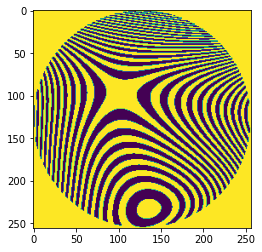

In [55]:
bi_phi = (xp.real(xp.exp(1j * cumphase))) > 0 * xp.pi
plt.figure()
if xp == cp:
    plt.imshow(xp.angle(xp.exp(1j * (bi_phi))).get())
else:
    plt.imshow(xp.angle(xp.exp(1j * (bi_phi))))
hol = xp.angle(xp.exp(1j * (bi_phi))).get()
cv2.imwrite('hol_test.png', hol, [cv2.IMWRITE_PNG_BILEVEL, 1])

In [ ]:
aaa = cupyx.scipy.ndimage.zoom((xp.real(xp.exp(1j * cumphase))) > 0 * xp.pi, 8, order=0)
plt.imshow(aaa.get())
print(aaa.shape)

In [ ]:
plt.figure(100)
if xp == cp:
    plt.imshow(xp.angle(xp.exp(1j * (ri))).get())
else:
    plt.imshow(xp.angle(xp.exp(1j * (ri))))
plt.title('Random target phase')

In [44]:
# zs = xp.zeros((1,21))
# Qc = cumphase

# # Constrain phase in pupil to have slowly varying values by fitting to Zernike
# Z_list = [Z00, Z11, Z1_1, Z20, Z22, Z2_2, Z31, Z3_1, Z33, Z3_3, Z40, Z42, Z4_2, Z44, Z4_4, Z51, Z5_1, Z53, Z5_3, Z55, Z5_5]

# for i in range(21):
#     zs[0, i] = xp.sum(Qc * Z_list[i])
# zs = zs/normval

Tried to make the retrived phase bianary, but failed. The PSF is too good to believe.

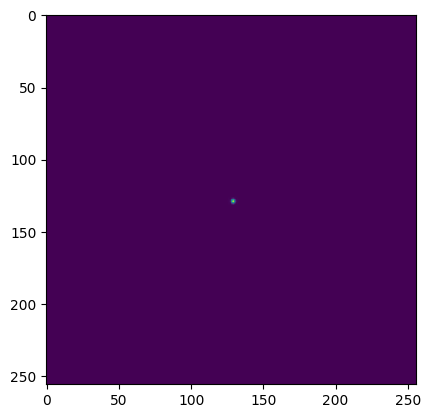

In [46]:
plt.figure()
p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * (ri-cumphase)), (2*N, 2*N)))
p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
p1i_n = (xp.random.poisson(p1i) - bg) * G
psf_test = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]
if xp == cp:
    plt.imshow(abs(psf_test).get())
else:
    plt.imshow(abs(psf_test))

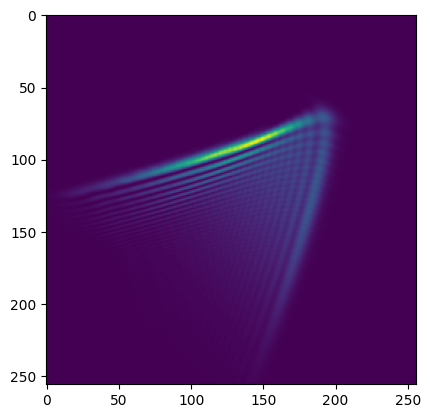

In [86]:
plt.figure()
p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * (cumphase)), (2*N, 2*N)))
p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
p1i_n = (xp.random.poisson(p1i) - bg) * G
psf_test = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]
if xp == cp:
    plt.imshow(abs(psf_test).get())
else:
    plt.imshow(abs(psf_test))

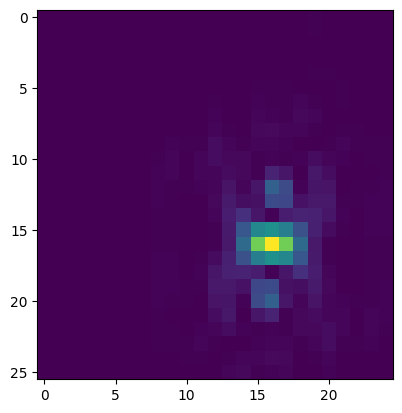

In [110]:
plt.imshow(abs(psfi[2]).get()[240:266, 240:265])

In [20]:
plt.figure()
p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * (ri-bi_phi)), (2*N, 2*N)))
p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
p1i_n = (xp.random.poisson(p1i) - bg) * G
psf_test = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]
if xp == cp:
    plt.imshow(abs(psf_test).get())
else:
    plt.imshow(abs(psf_test))

NameError: name 'bi_phi' is not defined

<Figure size 640x480 with 0 Axes>

In [21]:
plt.figure()
p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * (bi_phi)), (2*N, 2*N)))
p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
p1i_n = (xp.random.poisson(p1i) - bg) * G
psf_test = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]
if xp == cp:
    plt.imshow(abs(psf_test).get())
else:
    plt.imshow(abs(psf_test))

NameError: name 'bi_phi' is not defined

<Figure size 640x480 with 0 Axes>

In [1175]:
print(psfi[0][138])

[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.          0.
  0.          0.          0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.          0.         -0.         -0.          0.          0.
  0.          0.          0.          0.         -0.         -0.
  0.          0.          0.          0.         -0.         -0.
 -0.          0.         -0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.
 -0.         -0.          0.          0.         -0.          0.
  0.          0.          0.          0.         -0.         -0.
  0.         -0.          0.          0.          0.          0.
  0.         -0.         

In [984]:
bi_phi.mean()

array(57.22026953)

In [985]:
ri.mean()

array(1.00986456)

In [986]:
cumphase.mean()

array(-18.65401583)

In [968]:
ri.max() -ri.min()

array(61.30535486)

In [987]:
cumphase.max() -cumphase.min()

array(61.84224315)

In [988]:
bi_phi.max() - bi_phi.min()

array(1.)

In [989]:
np.max(cumphase)

array(5.01079808)

In [564]:
xp.sum(psfi[0])

array(69116157.32964002+0.j)

In [475]:
cumphase_norm.max()

array(6.25224269)